In [237]:
#@title
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GaussianNoise
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from random import choice
from random import uniform
from numpy.random import randint
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

	

Pull the dataset and plot some sample images

Train: X=(2500, 28, 28), y=(2500,)
Test: X=(1000, 28, 28), y=(1000,)


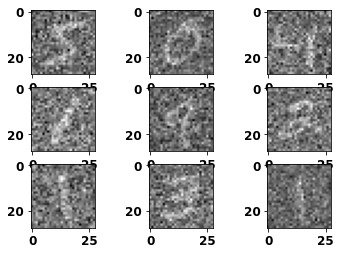

In [238]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# Pull only a subset of images 
# Using only 2500 images, might shrink 
trainX = trainX[:2500]
trainY = trainY[:2500]
testX = testX[:1000]
testY = testY[:1000]

trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255
sample = GaussianNoise(0.6)
trainX = sample(trainX, training=True)
testX = sample(testX, training=True)
trainX = trainX.numpy()
testX = testX.numpy()
trainX = trainX.astype('float32') * 255
testX = testX.astype('float32') * 255


# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Using CNN Example from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

Preprocess the dataset, reshape the images to a single color channel 

and "one hot" encode the y_lablels
i.e. the label '3' -> [0,0,0,1,0,0,0,0,0,0] 

In [239]:
# Preprocess train and test dataset
def PreProcess(trainX, trainY, testX, testY, ds="MNIST"):
    #convert single color channel
    if ds=="MNIST":
        trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
        testX = testX.reshape((testX.shape[0], 28, 28, 1))

   
    return trainX, trainY, testX, testY

Normalize pixel values, so high/low pixel values are not weighted to highly by the network

In [240]:
# scale pixels
def PrepPixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

Finally the network
we've got a convolutional layer -> max_pooling -> dense layer

In [241]:
def CNN_MNIST(f1, k, a1, a2, trainX, trainY, testX, testY):
	model = Sequential()
	model.add(Conv2D(filters=f1, kernel_size=(k, k), activation=a1, kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation=a2, kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))

	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	es = EarlyStopping(monitor="loss", patience = 3)
	model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size = 32, verbose=0, callbacks=[es])

	return model
# Roulette wheel selection method
def selection(population_fitness):
  total = sum(population_fitness)
  percentage = [round((x/total) * 100) for x in population_fitness]
  selection_wheel = []
  for pop_index,num in enumerate(percentage):
    selection_wheel.extend([pop_index]*num)
  parent1_ind = choice(selection_wheel)
  parent2_ind = choice(selection_wheel)
  return [parent1_ind, parent2_ind]

In [242]:
def generate_population(n):
  population = []
  for i in range(n):
    chromosome = initialization()
    population.append(chromosome)
  return population

In [243]:
def initialization():  
  parameters = {}
  f1 = choice([32, 64])
  parameters["f1"] = f1
  #f2 = choice([64, 128])
  #parameters["f2"] = f2
  #f3 = choice([128, 256, 512])
  #parameters["f3"] = f3
  k = choice([3,5])
  parameters["k"] = k
  a1 = choice(["relu", "selu", "elu"])
  parameters["a1"] = a1
  a2 = choice(["relu", "selu", "elu"])
  parameters["a2"] = a2
  #d1 = round(uniform(0.1, 0.5), 1)
  #parameters["d1"] = d1
  #d2 = round(uniform(0.1, 0.5), 1)
  #parameters["d2"] = d2
  #op = choice(["adamax", "adadelta", "adam", "adagrad"])
  #parameters["op"] = op
  #ep = randint(50, 70)
  #parameters["ep"] = ep
  return parameters

In [244]:
def crossover(parent1, parent2):
  child1 = {}
  child2 = {}

  child1["f1"] = choice([parent1["f1"], parent2["f1"]])
  child2["f1"] = choice([parent1["f1"], parent2["f1"]])

  child1["k"] = choice([parent1["k"], parent2["k"]])
  child2["k"] = choice([parent1["k"], parent2["k"]])

  child1["a1"] = parent1["a2"]
  child2["a1"] = parent2["a2"]

  child1["a2"] = parent2["a1"]
  child2["a2"] = parent1["a1"]

  return [child1, child2]

In [245]:
def mutation(chromosome):
  flag = randint(0,40)
  #if flag <= 20:
  #  chromosome["ep"] += randint(0, 10)
  return chromosome

In [246]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# Fitness evaluation metric: Classification Accuracy 
def fitness_evaluation(model, test_images, test_labels):
  #metrics = model.evaluate(test_images, test_labels)
  y_pred = model.predict(test_images)
  #Class balanced accuracy
  y_pred = np.argmax(y_pred, axis=1)
  y_true = np.argmax(test_labels, axis=1)
  acc  = balanced_accuracy_score(y_true, y_pred=y_pred)
  return acc

Graphs/Figures/Results TODO: 
* Implement k-fold cross validation (Caleb) 
* Plot avg and standard deviations (Calvin)
* plot changing avg accuracy each gen (Anthony)
* 
1. Collect data with varying number of generations 
2. Collect data with variying population 
3. Implement on CIFAR - Change model / parameter space. 

In [247]:
trainX, trainY, testX, testY = PreProcess(trainX, trainY, testX, testY)
	# prepare pixel data
trainX, testX = PrepPixels(trainX, testX)

In [248]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from statistics import median, mean
generations = 10
threshold = .98
num_pop = 2


skfolds = StratifiedKFold( n_splits=3 , shuffle=True, random_state=42)

population = generate_population(num_pop)
global_acc = []

all_fitnesses = []
best_accuracies_per_gen = []

for generation in range(generations):

    population_fitness = []
    best_chromosome = []
    #Iterate through the population
    for chromosome in population:
        f1 = chromosome["f1"]
        k = chromosome["k"]
        a1 = chromosome["a1"]
        a2 = chromosome["a2"]
       # op = chromosome["op"]

        try:
            kfold_accs = []
            #K fold cross validation
            
            print("Parameters: ", chromosome)
            for train_index , test_index in skfolds.split(trainX, trainY):
                
                X_train_folds = trainX [train_index]
                Y_train_folds = trainY[train_index]
                X_test_fold = trainX[test_index]
                Y_test_fold = trainY [test_index]
                #one hot encode labels
                Y_train_folds = to_categorical(Y_train_folds)
                Y_test_fold  = to_categorical(Y_test_fold)
                model = CNN_MNIST(f1, k, a1, a2, X_train_folds, Y_train_folds, X_test_fold, Y_test_fold)
                #history = model.fit(trainX, trainY, epochs=1, batch_size=32, validation_data=(testX, testY), verbose=1)
                acc = fitness_evaluation(model, X_test_fold, Y_test_fold)
                kfold_accs.append(acc)    
                print("Accuracy: ", round(acc, 3))

            foldacc = mean(kfold_accs)
            best_chromosome.append(kfold_accs)
            print("Parameters: ", chromosome)
            print("avg Accuracy accross folds: ", round(foldacc, 3))
            population_fitness.append(foldacc)
            #all_fitnesses[generation].append(foldacc)
            global_acc.append(foldacc)
            if foldacc >= max(global_acc):
                best_params = chromosome
            
        except Exception as e:
            acc = 0
            print("Invalid parameters - Build fail")
            print(e)

    print("population fitesses", population_fitness)
    all_fitnesses.append(population_fitness)

    max_mean = 0
    for accs in best_chromosome :
        if mean(accs) > max_mean :
            max_mean = mean(accs)
        else :
            best_chromosome.remove(accs)

    best_accuracies_per_gen.append(best_chromosome)
    print("Best accuracies so far: ", best_accuracies_per_gen)

    parents_ind = selection(population_fitness)
    parent1 = population[parents_ind[0]]
    parent2 = population[parents_ind[1]]

    children = crossover(parent1, parent2)
    child1 = mutation(children[0])
    child2 = mutation(children[1])

    population.append(child1)
    population.append(child2)

    print("Generation ", generation+1, " Outcome: ")
    if max(population_fitness) >= threshold:
        print("Obtained desired accuracy: ", max(population_fitness))
        break
    else:
        print("Maximum avg accuracy in generation {} : {}".format(
            generation+1, max(population_fitness)))

    first_min = min(population_fitness)
    first_min_ind = population_fitness.index(first_min)
    population.remove(population[first_min_ind])
    second_min = min(population_fitness)
    second_min_ind = population_fitness.index(second_min)
    population.remove(population[second_min_ind])


Parameters:  {'f1': 32, 'k': 5, 'a1': 'relu', 'a2': 'elu'}
Accuracy:  0.757
Accuracy:  0.806
Accuracy:  0.752
Parameters:  {'f1': 32, 'k': 5, 'a1': 'relu', 'a2': 'elu'}
avg Accuracy accross folds:  0.772
Parameters:  {'f1': 64, 'k': 5, 'a1': 'elu', 'a2': 'selu'}
Accuracy:  0.738
Accuracy:  0.768
Accuracy:  0.641
Parameters:  {'f1': 64, 'k': 5, 'a1': 'elu', 'a2': 'selu'}
avg Accuracy accross folds:  0.716
population fitesses [0.7716540869932579, 0.7156719664029159]
Best accuracies so far:  [[[0.7566743045178439, 0.8060669260750574, 0.7522210303868724]]]
Generation  1  Outcome: 
Maximum avg accuracy in generation 1 : 0.7716540869932579
Parameters:  {'f1': 32, 'k': 5, 'a1': 'relu', 'a2': 'elu'}
Accuracy:  0.735
Accuracy:  0.788
Accuracy:  0.757
Parameters:  {'f1': 32, 'k': 5, 'a1': 'relu', 'a2': 'elu'}
avg Accuracy accross folds:  0.76
Parameters:  {'f1': 32, 'k': 5, 'a1': 'elu', 'a2': 'relu'}
Accuracy:  0.738
Accuracy:  0.756
Accuracy:  0.772
Parameters:  {'f1': 32, 'k': 5, 'a1': 'elu', 

In [249]:
f1 = best_params["f1"]
k = best_params["k"]
a1 = best_params["a1"]
a2 = best_params["a2"]
#op = best_params["op"]
trainY = to_categorical(trainY)
testY  = to_categorical(testY)
model = CNN_MNIST(f1, k, a1, a2, trainX, trainY, testX, testY)
y_score = model.predict(testX)
y_pred = np.argmax(y_score, axis=1)
y_true = np.argmax(testY, axis=1)
acc = fitness_evaluation(model, testX, testY)
print(acc)

0.7537767020273124


In [250]:
from sklearn.metrics import confusion_matrix

#labels = ['0','1','2','3','4','5','6','7','8','9']
confusion_matrix(y_true, y_pred)

array([[ 75,   0,   2,   0,   0,   3,   1,   2,   0,   2],
       [  0, 120,   0,   1,   0,   2,   1,   0,   1,   1],
       [  0,   3,  93,   6,   0,   0,   5,   3,   5,   1],
       [  0,   3,   5,  71,   1,  21,   1,   2,   1,   2],
       [  0,   1,   2,   0,  81,   0,   4,   1,   2,  19],
       [  2,   1,   2,   5,   3,  53,   1,   4,  11,   5],
       [  3,   0,   4,   0,   5,   5,  70,   0,   0,   0],
       [  0,   4,   6,   5,   1,   0,   1,  73,   1,   8],
       [  1,   1,   5,   4,   4,   8,   7,   2,  52,   5],
       [  0,   0,   1,   5,   6,   1,   1,   7,   1,  72]], dtype=int64)

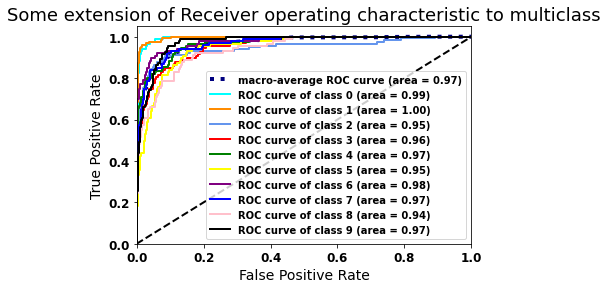

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
n_classes = 10
lw = 2


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testY.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure()
#plt.plot(
#    fpr["micro"],
#    tpr["micro"],
#    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#    color="deeppink",
#    linestyle=":",
#    linewidth=4,
#)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "yellow", "purple", "blue", "pink", "black"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


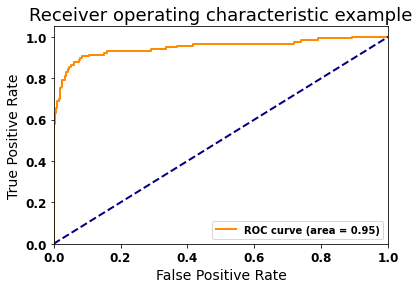

In [252]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

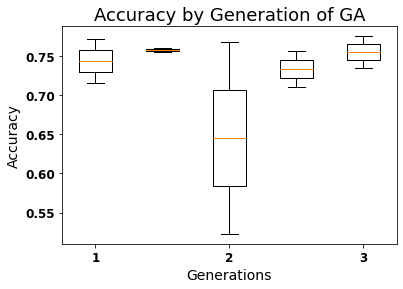

In [253]:
# Plot fitness as a box plot for each generation
plt.figure()

plt.boxplot(all_fitnesses, vert=True)
plt.xticks(range(1, generations+1, 2))
plt.ylabel("Accuracy")
plt.xlabel("Generations")
plt.title("Accuracy by Generation of GA")

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)

plt.tight_layout()
plt.savefig('figures/' + str(generations) + '_' + str(num_pop) + '_' + 'AccuracyOfPopulation' + '.png', facecolor='white', transparent=False)
plt.show()


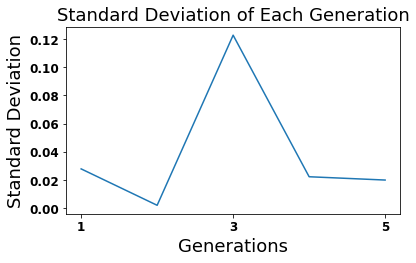

In [254]:
# Plot fitness as a box plot for each generation
std_deviations = []
for generation in all_fitnesses :
    mean = sum(generation) / len(generation)
    variance = sum([((x - mean) ** 2) for x in generation]) / len(generation)
    std_deviations.append(variance ** 0.5)
    
plt.figure()

plt.plot(range(1, generations+1), std_deviations)
plt.xticks(range(1, generations+1, 2))
plt.ylabel("Standard Deviation")
plt.xlabel("Generations")
plt.title("Standard Deviation of Each Generation")

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)

plt.tight_layout()
plt.savefig('figures/' + str(generations) + '_' + str(num_pop) + '_' + 'StdDevOfPopulation' + '.png', facecolor='white', transparent=False)
plt.show()



[[[0.7566743045178439, 0.8060669260750574, 0.7522210303868724]], [[0.734584123345151, 0.7879535724340236, 0.7571151886067774]], [[0.7964503856118827, 0.7736267816238617, 0.7340951483335971]], [[0.7628206448134097, 0.7596642842343387, 0.7454773760264577]], [[0.7753293239752437, 0.7867736789195928, 0.7643955904299277]]]


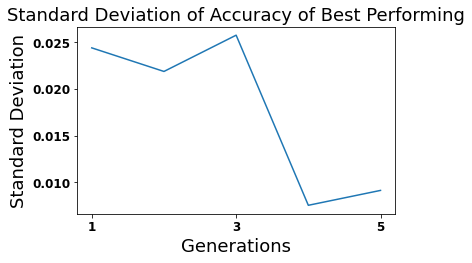

In [266]:
# Plot fitness as a box plot for each generation

std_deviations = []
print(best_accuracies_per_gen)
for generation in best_accuracies_per_gen :
    mean = sum(generation[0]) / len(generation[0])
    variance = sum([((x - mean) ** 2) for x in generation[0]]) / len(generation[0])
    std_deviations.append(variance ** 0.5)
    
plt.figure()

plt.plot(range(1, generations+1), std_deviations)
plt.xticks(range(1, generations+1, 2))
plt.ylabel("Standard Deviation")
plt.xlabel("Generations")
plt.title("Standard Deviation of Accuracy of Best Performing")

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)

plt.tight_layout()
plt.savefig('figures/' + str(generations) + '_' + str(num_pop) + '_' + 'StdDevOfBestPerforming' + '.png', facecolor='white', transparent=False)
plt.show()